### Import libraries

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import PorterStemmer
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes, svm

#nltk.download('stopwords')

### Read data

In [53]:
raw_df = pd.read_csv('data/amazon_data.csv')
df = raw_df[['Text', 'Score']]

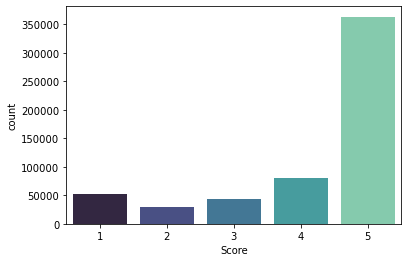

In [54]:
sns.countplot(x=df['Score'], palette='mako')
plt.show()

In [55]:
df['Score'].value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

### Balance target variable

In [56]:
sample_size = 1000

df_1 = df[df['Score'] == 1].sample(n=sample_size, random_state=101)
df_2 = df[df['Score'] == 2].sample(n=sample_size, random_state=101)
df_3 = df[df['Score'] == 3].sample(n=sample_size, random_state=101)
df_4 = df[df['Score'] == 4].sample(n=sample_size, random_state=101)
df_5 = df[df['Score'] == 5].sample(n=sample_size, random_state=101)

df = pd.concat([df_1, df_2, df_3, df_4, df_5])

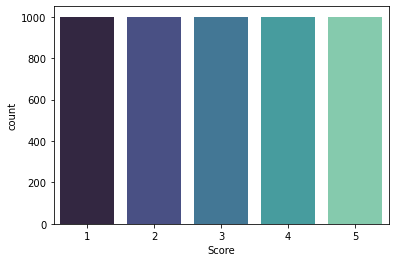

In [57]:
sns.countplot(x=df['Score'], palette='mako')
plt.show()

### Preprocessing

In [58]:
%%time
processed_df = df.copy()

# Remove punctuation
processed_df['Text'] = processed_df['Text'].str.replace(r'[^\w\d\s]', ' ', regex=True)

# Replace numbers with 'numbr'
processed_df['Text'] = processed_df['Text'].str.replace(r'\d+(\.\d+)?', 'numbr', regex=True)

# Replace whitespace between terms with a single space
processed_df['Text'] = processed_df['Text'].str.replace(r'\s+', ' ', regex=True)

# Remove leading and trailing whitespace
processed_df['Text'] = processed_df['Text'].str.replace(r'^\s+|\s+?$', '', regex=True)

#All words to lowercase
processed_df['Text'] = processed_df['Text'].str.lower()

# remove stop words from text messages
stop_words = set(stopwords.words('english'))
processed_df['Text'] = processed_df['Text'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

# Remove word stems using a Porter stemmer
ps = PorterStemmer()
processed_df['Text'] = processed_df['Text'].apply(lambda x: ' '.join(ps.stem(term) for term in x.split()))

Wall time: 3.48 s


In [59]:
processed_df['Text'].head()

392819    descript mention flavor coffe name thought jam...
192649    cereal numbr month expir upon arriv figur tri ...
423389    given name talent behind convinc would awesom ...
456690    everyon gave treat rave review thought would g...
25365     westi yorki eat can food thought might find sl...
Name: Text, dtype: object

### Create dataset

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(ngram_range=(1, 2), max_features=200).fit(processed_df['Text'])
X = vect.transform(processed_df['Text'])

print(X)

  (0, 183)	0.43604857570783706
  (0, 175)	0.23478106801136386
  (0, 77)	0.2616837032887455
  (0, 69)	0.5448111137693019
  (0, 38)	0.3504576658681597
  (0, 22)	0.5163539521562627
  (1, 194)	0.3278573978352675
  (1, 187)	0.25173679951250755
  (1, 170)	0.4026720565005561
  (1, 120)	0.2103235140644665
  (1, 112)	0.41042286680593076
  (1, 77)	0.23154400542472317
  (1, 75)	0.3445274866000715
  (1, 56)	0.3097886936274416
  (1, 10)	0.4313114478348467
  (2, 198)	0.16699367857203923
  (2, 197)	0.11784974040645377
  (2, 189)	0.2546191834099847
  (2, 187)	0.3249523365704015
  (2, 182)	0.12252286353689418
  (2, 178)	0.11323608865083143
  (2, 175)	0.0670398300718384
  (2, 167)	0.11450133947185064
  (2, 164)	0.11895812286655673
  (2, 159)	0.12028450787119264
  :	:
  (4998, 67)	0.08790507058826363
  (4998, 66)	0.06639175446908939
  (4998, 58)	0.07900483311036487
  (4998, 56)	0.6150551078816687
  (4998, 48)	0.08358686375585238
  (4998, 35)	0.09470525898145217
  (4998, 34)	0.08632879794815466
  (4998, 3

In [61]:
reviews_transformed = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
reviews_transformed.head()

,actual,ad,add,almost,also,alway,amazon,amount,anoth,anyth,...,want,water,way,week,well,whole,without,work,would,year
0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0
1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.327857,0.0,0.0,0.00000,0.000000,0.0
2,0.000000,0.0,0.0,0.0,0.102205,0.0,0.000000,0.0,0.0,0.135435,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.11785,0.166994,0.0
3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.150068,...,0.0,0.0,0.0,0.0,0.117234,0.0,0.0,0.00000,0.185036,0.0
4,0.121719,0.0,0.0,0.0,0.000000,0.0,0.380612,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.079355,0.0


### Model

In [62]:
X_train, X_test, y_train, y_test = train_test_split(reviews_transformed, processed_df['Score'], test_size=0.2, random_state=456)

In [63]:
%%time
log_reg = LogisticRegression(max_iter=200).fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
score = accuracy_score(y_test,y_pred)

print('Accuracy: {}%'.format(round(score*100,2)))

Accuracy: 38.3%
Wall time: 140 ms


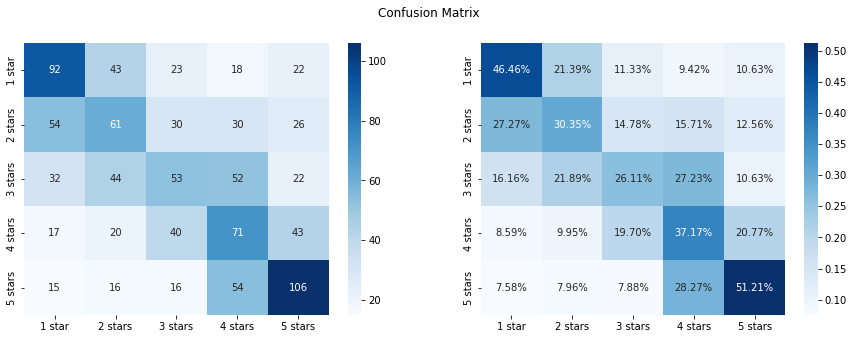

In [64]:
confusion = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Confusion Matrix')
categories = ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']
sns.heatmap(ax=axes[0], data=confusion, annot=True, fmt='g', cmap='Blues', xticklabels=categories, yticklabels=categories)
sns.heatmap(ax=axes[1], data=confusion/np.sum(confusion, axis=1), annot=True, fmt='.2%', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.show()

In [65]:
%%time
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train,y_train)

# predict the labels on validation dataset
y_pred = Naive.predict(X_test)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(y_pred, y_test)*100)

Naive Bayes Accuracy Score ->  38.800000000000004
Wall time: 8.97 ms


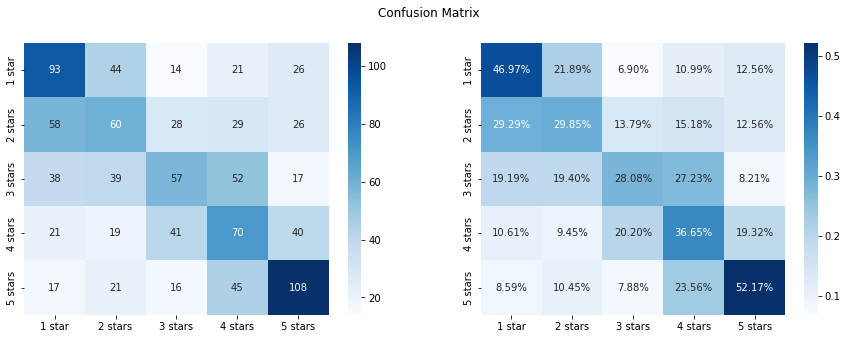

In [66]:
confusion = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Confusion Matrix')
categories = ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']
sns.heatmap(ax=axes[0], data=confusion, annot=True, fmt='g', cmap='Blues', xticklabels=categories, yticklabels=categories)
sns.heatmap(ax=axes[1], data=confusion/np.sum(confusion, axis=1), annot=True, fmt='.2%', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.show()

In [74]:
%%time
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train, y_train)
# predict the labels on validation dataset
y_pred = SVM.predict(X_test)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(y_pred, y_test)*100)

SVM Accuracy Score ->  38.4
Wall time: 1.26 s


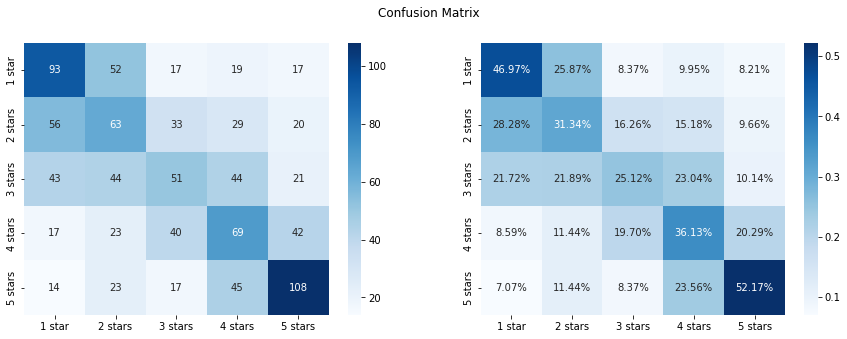

In [68]:
confusion = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Confusion Matrix')
categories = ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']
sns.heatmap(ax=axes[0], data=confusion, annot=True, fmt='g', cmap='Blues', xticklabels=categories, yticklabels=categories)
sns.heatmap(ax=axes[1], data=confusion/np.sum(confusion, axis=1), annot=True, fmt='.2%', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.show()